In [2]:
import pickle
import numpy as np
from multiprocessing import Pool
# !pip install distinctipy

import requests, json
import pandas as pd
import glob
import time
from multiprocessing import Pool
import numpy as np
from scipy import stats

def toc(start_time):
    elapsed = timeit.default_timer() - start_time
    print(elapsed)
# from zipfile import ZipFile
import re
# from pprint import pprint
# import glob
import pickle

import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as mtransforms
sns.set_theme(style='white')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.set_context('talk', font_scale=.65)
mpl.rcParams.update({'text.usetex': False})

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
import pandas as pd
df_submissions=pd.read_csv('submissions_reddit.csv')
df_comments=pd.read_csv('comments_reddit.csv')

In [4]:
# df_submissions.sort_values(['created_utc'],ascending=False)
df_submissions['created_utc_'] = pd.to_datetime(df_submissions['created_utc'], unit='s')


In [4]:
len(df_submissions['subreddit'].unique())
# number of unique subreddits

11165

In [5]:
len(df_comments['subreddit'].unique())


3794

## Filtering subreddits on relevance and activity 

In [5]:
irrelevant_items = ["meatcanyon", "happymeatfarms", "themeatz","mytimeatportia","thighmeat", "datbootymeat", "videomeat", "u_meatierman", "chavmeat2", "gameattack", "freshmeattv","00darkmeatbuffet","satxmeatmarket", "jackmeatsflix","mytimeatsandrock","joinmeatthecampfire","u_meatsandwit","supermeatboy","meatosubincision","rollerderby_freshmeat","meatslap", "labiadarkmeat","uncutmanmeat","shittyveganfoodporn","water_on_the_meat_sex","beatthemeat", "fuckmeat","chavmeat","cumeatingcuckolds","deadmeatjames","cumeatinginstructions","meatyvaginas","cumeatinginstruction","hangnmeat","u_jigglybootymeat","sweatermeat","u_blaqmeat","beatmeattoit",    "u_confident_climate_11",    "fuckmeat2",    "u_meaty-midgets",    "u_slutmeatcunt",    "africanbootymeat",    "meatyflesh",    "u_unfairmeat71266",    "u_unfairmeat7126",    "jigglybootymeat",    "meatlessmealprep",    "meatwalls",    "gradeafuckmeat",    "smalldelimeats",    "meatcrayon",    "femdomcumeatingh",    "thatveganteachersucks",    "veganforbeginners",    "meatloaf",    "redmeatscience",    "censored_meat",    "beatmymeattoit",    "rapemeat",    "vegan_fashionadvice",    "rmeatwife",    "forcedcumeating",    "fuckmeat_sluts",    "meatporn",    "meatheads",    "meatygirls",    "rubmymeatandsmokeme",    "u_meatgodnc336",    "u_meatgodofficial",    "bumbblondefuckmeat"];



df_submissions['filter']= (df_submissions['subreddit'].isin(irrelevant_items))| (df_submissions['subreddit'].str.contains('puss')) | (df_submissions['subreddit'].str.contains('onlyfans')) | (df_submissions['subreddit'].str.contains('cumeat')) | (df_submissions['subreddit'].str.contains('sweatermeat')) 
df_submissions_filtered=df_submissions[df_submissions['filter']==False]

min_posts_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = df_submissions_filtered['subreddit'].value_counts() # Entire DataFrame 
dict_subreddit_to_numposts={}
for x in zip(value_counts.index,value_counts):
    dict_subreddit_to_numposts[x[0]]=x[1]   
df_submissions_filtered['num_posts_on_subreddit']=df_submissions_filtered['subreddit'].map(dict_subreddit_to_numposts);
df_submissions_filtered=df_submissions_filtered[df_submissions_filtered['num_posts_on_subreddit']>=min_posts_threshold]

#(df_submissions['num_comments']<1) & & (df_submissions['subreddit_subscribers']>100) this removes the subreddits which have nan as subscribers

C:\Users\Chowdhary\AppData\Local\Temp\48\ipykernel_120980\3733916304.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submissions_filtered['num_posts_on_subreddit']=df_submissions_filtered['subreddit'].map(dict_subreddit_to_numposts);


In [6]:
top_subreddits=df_submissions_filtered.groupby(by='subreddit')['num_posts_on_subreddit'].mean().sort_values(ascending=False)
top100subreddits=top_subreddits[0:100].index

In [160]:
 # np.where(top100subreddits=='debateavegan')

(array([17], dtype=int64),)

In [8]:
# top100subreddits[17]

### filter comments to these subreddits

In [7]:
# dict_subreddit_in_top100={}
# for x in top100subreddits:
#     dict_subreddit_in_top100[x]=True  
    
commentintop100subreddit=[x in top100subreddits for x in list(df_comments['subreddit'])]
df_comments['commentintop100subreddit']=commentintop100subreddit
df_comments_filtered=df_comments[df_comments['commentintop100subreddit']==True]
# link_id is id of parent submission

In [10]:
import numpy as np
round(100*np.sum((commentintop100subreddit))/len(commentintop100subreddit),1)

90.8

### cross-posts

In [45]:
round(100*df_submissions_filtered[df_submissions_filtered['num_crossposts']>0].shape[0]/df_submissions_filtered.shape[0],1)

2.1

Only 2% of Submissions are posted across subreddits.

In [44]:
round(100*df_submissions_filtered[df_submissions_filtered['num_crossposts']>1].shape[0]/df_submissions_filtered.shape[0],1)

0.5

### users number of comments in a subreddit

In [89]:
# df_comments_filtered

In [51]:
num_comments_per_user=df_comments_filtered.groupby('author').count()

In [80]:
# num_comments_per_user=df_comments_filtered.groupby('author')['subreddit'].apply(list).count()
num_subreddits_per_user=df_comments_filtered.groupby('author')['subreddit'].nunique()



In [54]:
# user_spread_across_100_subreddits=list(X['subreddit'])

In [68]:
import collections

c = collections.Counter(num_subreddits_per_user)
c=c.most_common(len(c))

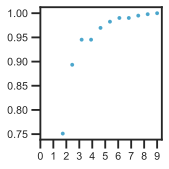

In [88]:
label_ff = 20;ff = 20;aa=14;bb=6;wspace_=.8;hspace_=.5;
fig = plt.figure(figsize=(aa, bb));
falph=.35
spec = gridspec.GridSpec(ncols=4, nrows=2,width_ratios=[1,1,1,1], wspace=wspace_,hspace=hspace_, height_ratios=[1,1])
custom_palette = ["#b3e2cd", "#fdcdac", "#cbd5e8",  "#f1e2cc","#e6f5c9", "#fff2ae", "#f4cae4",]
sns.set_style("ticks")
taxX=-.45
#____________________________________________
ax = fig.add_subplot(spec[0]);

def plotCDF(ax,data,label,nbin,color,showpdf=False):
    al=.9
    count, bins_count = np.histogram(data, bins=nbin)
    # finding the PDF of the histogram using count values
    pdf = count / sum(count)
    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    # plotting PDF and CDF
    if showpdf==True:
        plt.plot(bins_count[1:], pdf, label=label+' pdf',alpha=al,color=color)
    ax.scatter(bins_count[1:], cdf,s=6, label=label,alpha=al,color=color);

nbin=11
num_subreddits_per_user=np.array(num_subreddits_per_user)
X=num_subreddits_per_user[num_subreddits_per_user<10]
colors=['#43a2ca','#a8ddb5']
plotCDF(ax,X,'data',nbin,colors[0]);
ax.set_xticks([x for x in range(0,10)]);

## climate subreddit only

### Topics model

In [95]:
df_sub_climate=df_submissions_filtered[df_submissions_filtered['subreddit']=='climate']
df_com_climate=df_comments_filtered[df_comments_filtered['subreddit']=='climate']

In [ ]:
df_com_climate.groupby(by='author').count()

,body,subreddit,created_utc,controversiality,score,link_id,parent_id,commentintop100subreddit
author,,,,,,,,
------why------,1,1,1,1,1,1,1,1
---sanguine---,1,1,1,1,1,1,1,1
--_-_o_-_--,138,138,138,138,138,138,138,138
--aldo--,2,2,2,2,2,2,2,2
--harumph--,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...
zzmeesheezz,1,1,1,1,1,1,1,1
zzsaltycrackerzz,1,1,1,1,1,1,1,1
zzz_ch,2,2,2,2,2,2,2,2


In [ ]:
# # Choose an embedding backend
# !pip install bertopic[flair, gensim, spacy, use]

# # Topic modeling with images
# !pip install bertopic[vision]

In [105]:
from bertopic import BERTopic
df_sub_climate['selftext']=df_sub_climate['selftext'].astype(str)
np.mean(df_sub_climate['selftext']!='nan')
### time it 
# topic_model = BERTopic()
# topics, probs = topic_model.fit_transform(df_sub_climate['title'])
freq = topic_model.get_topic_info()
freq.head(20)

In [126]:
### time it 
# topic_model = BERTopic()
# topics, probs = topic_model.fit_transform(df_sub_climate['title'])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [130]:
topics?

Type:        list
String form: [-1, 245, 35, 181, 373, 111, -1, -1, 629, -1, 245, -1, 119, 95, 27, 119, 71, -1, 907, -1, 4, -1,  <...> , -1, 943, -1, -1, 54, 104, 141, 125, -1, 20, -1, -1, -1, 565, -1, 66, 368, 54, 71, -1, 744, 955]
Length:      87354
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

In [143]:
freq = topic_model.get_topic_info()
freq.head(20)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,32386,-1_energy_ice_emissions_coal,"[energy, ice, emissions, coal, of, and, to, gl...",[Coastal flooding in US will continue to incre...
1,0,705,0_warmest_hottest_record_month,"[warmest, hottest, record, month, consecutive,...",[Last Year Was Second-Warmest and Decade Hotte...
2,1,664,1_solar_panels_rooftop_power,"[solar, panels, rooftop, power, farm, sun, pv,...","[Rooftop Solar Side Project, Of course Califor..."
3,2,644,2_trump_trumps_donald_president,"[trump, trumps, donald, president, administrat...",[Donald Trump presidency a 'disaster for the p...
4,3,563,3_biden_bidens_joe_president,"[biden, bidens, joe, president, executive, his...",[‘Biggest step forward on climate ever’: Biden...
5,4,535,4_exxon_exxonmobil_mobil_exxons,"[exxon, exxonmobil, mobil, exxons, knew, fraud...",[Exxon Mobil Faces Off Against Activist Invest...
6,5,533,5_cop27_cop26_summit_egypt,"[cop27, cop26, summit, egypt, cop24, cop25, co...","[COP26: Climate Change, How likely is progress..."
7,6,499,6_solutions_fight_ways_do,"[solutions, fight, ways, do, fix, can, solutio...","[What can we do to fight Global Warming?, 3 Cl..."
8,7,497,7_agriculture_farmers_wheat_farming,"[agriculture, farmers, wheat, farming, crop, c...","[The U.S. Wheat Crop Is in Trouble, Farmers fa..."
9,8,467,8_trees_tree_planting_forests,"[trees, tree, planting, forests, forest, plant...",[Planting trees is not enough to stop climate ...


In [141]:
# topic_model.get_document_info(titles)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Climate Literacy: The Essential Principles of ...,-1,-1_energy_ice_emissions_coal,"[energy, ice, emissions, coal, of, and, to, gl...",[Coastal flooding in US will continue to incre...,energy - ice - emissions - coal - of - and - t...,0.000000,False
1,Climate change causes a decrease in dissolved ...,245,245_oxygen_zones_dissolved_oceans,"[oxygen, zones, dissolved, oceans, phytoplankt...",[New research reveals extreme oxygen loss in o...,oxygen - zones - dissolved - oceans - phytopla...,0.628959,False
2,Understanding the results of studies about hur...,35,35_hurricanes_hurricane_atlantic_season,"[hurricanes, hurricane, atlantic, season, stor...","[Hurricanes and Hope, Climate change and hurri...",hurricanes - hurricane - atlantic - season - s...,1.000000,False
3,"Since we've just started to measure, we know a...",181,181_circulation_atlantic_overturning_meridional,"[circulation, atlantic, overturning, meridiona...",[Stronger evidence for a weaker Atlantic overt...,circulation - atlantic - overturning - meridio...,0.834456,False
4,National Acadamies of the Sciences booklet pro...,373,373_evidence_anthropogenic_proof_systematic,"[evidence, anthropogenic, proof, systematic, r...",[NO EXPERIMENTAL EVIDENCE FOR THE SIGNIFICANT ...,evidence - anthropogenic - proof - systematic ...,0.647276,False
...,...,...,...,...,...,...,...,...
87349,‘Slipping through our fingers’: New Zealand sc...,54,54_glaciers_glacier_melting_melt,"[glaciers, glacier, melting, melt, disappear, ...","[Shrinking glaciers, growing glaciers, Glacier...",glaciers - glacier - melting - melt - disappea...,0.858089,False
87350,That Viral Liquid Tree Could Help Cut Down CO2...,71,71_forests_forest_tropical_offsets,"[forests, forest, tropical, offsets, trees, ab...",[Tropical forests losing their ability to abso...,forests - forest - tropical - offsets - trees ...,1.000000,False
87351,Four climate activists convicted of causing pu...,-1,-1_energy_ice_emissions_coal,"[energy, ice, emissions, coal, of, and, to, gl...",[Coastal flooding in US will continue to incre...,energy - ice - emissions - coal - of - and - t...,0.000000,False
87352,California to Require Half of All Heavy Trucks...,744,744_trucks_mandate_electric_california,"[trucks, mandate, electric, california, diesel...",[Governor Brown sets goal of 5 million electri...,trucks - mandate - electric - california - die...,1.000000,False


### climate subreddit social network

In [ ]:
# df_com_climate['created_utc_'] = pd.to_datetime(df_com_climate['created_utc'], unit='s')


In [149]:
df_sub_climate.sort_values('num_comments',ascending=False)


,author,title,subreddit,selftext,created_utc,num_comments,num_crossposts,score,id,subreddit_subscribers,upvote_ratio,created_utc_,filter,num_posts_on_subreddit
1928985,cnbc_official,Bill Gates on why he’ll carry on using private...,climate,nan,1675773769,2815,7.0,12162,10w0v9z,155777.0,0.85,2023-02-07 12:42:49,False,87354
1966998,burtzev,Scientists deliver ‘final warning’ on climate ...,climate,nan,1679320725,1954,6.0,10827,11wjlno,157979.0,0.86,2023-03-20 13:58:45,False,87354
1950825,enkrstic,Greta Thunberg removed by cops in Norway durin...,climate,nan,1677669340,1113,2.0,2780,11f15g3,158008.0,0.83,2023-03-01 11:15:40,False,87354
1481675,treebeard280,"To celebrate my cake day, I will plant a tree ...",climate,I will see how many comments this post gets af...,1635923338,1013,0.0,458,qlp0tr,126514.0,0.98,2021-11-03 07:08:58,False,87354
1637752,oldgrowthforests,Eat. Less. Meat,climate,nan,1649899606,857,2.0,0,u35s23,122056.0,0.46,2022-04-14 01:26:46,False,87354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393123,ecointernetnewsfeed,Fracking Study Finds Low Birth Weights Near Na...,climate,nan,1513202712,0,0.0,6,7jmscc,NaN,NaN,2017-12-13 22:05:12,False,87354
393137,getrealitychecks,Q: Can growth be decoupled from emissions? A: ...,climate,nan,1513177342,0,0.0,1,7jjsh6,NaN,NaN,2017-12-13 15:02:22,False,87354
393180,avogadros_number,The Dirty Secret of the Global Plan to Avert C...,climate,nan,1513184070,0,0.0,5,7jkjz9,NaN,NaN,2017-12-13 16:54:30,False,87354
393184,avogadros_number,Arctic Sea Ice Hits Yet Another Brutal Milestone,climate,nan,1513184340,0,0.0,10,7jkl3i,NaN,NaN,2017-12-13 16:59:00,False,87354


,author,body,subreddit,created_utc,controversiality,score,link_id,parent_id,commentintop100subreddit,created_utc_


In [153]:
df_com_climate['link_id_trimmed']=df_com_climate['link_id'].str.replace('t3_','')

In [155]:
df_com_climate[df_com_climate['link_id_trimmed']=='10w0v9z']

,author,body,subreddit,created_utc,controversiality,score,link_id,parent_id,commentintop100subreddit,created_utc_,link_id_trimmed
14602735,zmitic,&gt;How are carbon capture companies a scam?\n...,climate,1675778703,0,4,t3_10w0v9z,t1_j7kfi1a,True,2023-02-07 14:05:03,10w0v9z
14602745,grumpy-senior,word salad much ?,climate,1675778743,0,2,t3_10w0v9z,t1_j7khw1n,True,2023-02-07 14:05:43,10w0v9z
14602748,cryptographerok6522,It’s a necessary evil so that he can do the wo...,climate,1675778768,0,22,t3_10w0v9z,t3_10w0v9z,True,2023-02-07 14:06:08,10w0v9z
14602915,cnbc_official,Bill Gates does not agree that using a private...,climate,1675773793,0,142,t3_10w0v9z,t3_10w0v9z,True,2023-02-07 12:43:13,10w0v9z
14602916,automoderator,[BP popularized the concept of a carbon footpr...,climate,1675773794,0,31,t3_10w0v9z,t1_j7kcd1b,True,2023-02-07 12:43:14,10w0v9z
...,...,...,...,...,...,...,...,...,...,...,...
14881422,flaky-ad-8235,“Carbon offsets”. Biggest climate scam ever ...,climate,1678795526,0,1,t3_10w0v9z,t3_10w0v9z,True,2023-03-14 12:05:26,10w0v9z
14901661,scorpiolaw,Honestly just because he isn't 100% shining b...,climate,1679024667,0,1,t3_10w0v9z,t1_j7kcd1b,True,2023-03-17 03:44:27,10w0v9z
14930512,rweber130,Bill Gates says he's not part of the problem b...,climate,1679361304,0,1,t3_10w0v9z,t1_j7kcd1b,True,2023-03-21 01:15:04,10w0v9z
14944876,sarcofaygo,You don't have to be saintly to use zoom inste...,climate,1679504427,0,1,t3_10w0v9z,t1_j7kpnzp,True,2023-03-22 17:00:27,10w0v9z


## debate a vegan subreddit

In [8]:
df_sub_debateavegan=df_submissions_filtered[df_submissions_filtered['subreddit']=='debateavegan']
df_com_debateavegan=df_comments_filtered[df_comments_filtered['subreddit']=='debateavegan']

In [9]:
import pandas as pd
import numpy as np
import os
import re
import torch
from transformers import pipeline
import gc
import warnings

# Filter UserWarnings from torch.utils.data.dataloader
warnings.filterwarnings('ignore', category=UserWarning, module='torch.utils.data.dataloader')

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} for processing.")
# import pandas as pd
# from transformers import pipeline, DistilBertTokenizer
# import time
# import torch
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# # Load the tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# # # Load the model
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
# # # Function to classify text for sentiment






Using cpu for processing.


In [ ]:
# import pandas as pd
# from transformers import pipeline, DistilBertTokenizer
# import time
# import torch
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# # Load the tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# # # Load the model
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
# # # Function to classify text for sentiment






In [10]:
from transformers import pipeline
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", tokenizer="SamLowe/roberta-base-go_emotions", max_length=512, truncation=True, top_k=None)

In [11]:
# df_submissions.sort_values(['created_utc'],ascending=False)
df_com_debateavegan['created_utc_'] = pd.to_datetime(df_com_debateavegan['created_utc'], unit='s')
df_com_debateavegan=df_com_debateavegan.sort_values(by=['link_id','created_utc_'])


C:\Users\Chowdhary\AppData\Local\Temp\48\ipykernel_120980\580979545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com_debateavegan['created_utc_'] = pd.to_datetime(df_com_debateavegan['created_utc'], unit='s')


In [123]:
df_com_debateavegan.iloc[1620]

author                           cyanidalcitrus
body                                    Okay :)
subreddit                          debateavegan
created_utc                          1672850005
controversiality                              0
score                                         1
link_id                              t3_102t7jd
parent_id                            t1_j2xa1d7
commentintop100subreddit                   True
created_utc_                2023-01-04 16:33:25
Name: 14329973, dtype: object

In [41]:
ListOfPosts

247

### a conversation of 263 comments

In [124]:
ListOfPosts=['t3_zzxxbd','t3_1000j1w','t3_1025a9d','t3_1025i1j','t3_102t7jd']
PostEmo={}
for it,post in zip(range(len(ListOfPosts)),ListOfPosts):
    print(it+1,len(ListOfPosts),end='\r')
    df=df_com_debateavegan[df_com_debateavegan['link_id']==post]
    sentences=list(df['body'])
    # sentences=[x.replace('\n','') for x in sentences]
    sentences=[x.replace(">","").replace("*","").replace("\n\n", " ").replace("\n", " ").replace("\t", " ").strip() for x in sentences]
    sentences=[x for x in sentences if x!='[removed]']
    T0=time.time();
    model_outputs = classifier(sentences,batch_size=10)
    T1=time.time();
    print('Time elasped= ', (T1-T0)/60 ,len(model_outputs))
    # model_outputs[100]
    comment_times=[x for x,y in zip(list(df['created_utc_']),list(df['body'])) if y!='[removed]']
    PostEmo[post]=[sentences,model_outputs,comment_times]

Time elasped=  0.6064952095349629 285
Time elasped=  0.6843257864316304 247
Time elasped=  1.2606110890706381 602
Time elasped=  0.09538154204686483 44
Time elasped=  0.19648778438568115 70


In [173]:
ListOfPosts
dict_postid_to_title=dict(zip(df_sub_debateavegan.id,df_sub_debateavegan.title))

'Animals are not equal to humans so the consideration around their unnecessary suffering need not be equal as well.'

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Function to aggregate emotions in windows
def aggregate_emotions(emotions_list, window_size=20, step=2):
    aggregated_emotions = []
    for i in range(0, len(emotions_list) - window_size + 1, step):
        window = emotions_list[i:i + window_size]
        flattened_window = [emotion for sublist in window for emotion in sublist]
        aggregated_emotions.append(flattened_window)
    return aggregated_emotions

# Calculate percentage of each emotion in each window
def calculate_percentages(aggregated_emotions):
    percentages = []
    for window in aggregated_emotions:
        total_emotions = len(window)
        counts = Counter(window)
        percentages.append({emotion: (count / total_emotions) * 100 for emotion, count in counts.items()})
    return percentages


def plot_trajectory(emotions_per_comment):
    # Aggregate and calculate
    aggregated_emotions = aggregate_emotions(emotions_per_comment)
    percentages = calculate_percentages(aggregated_emotions)
    emotions_set = set([emotion for window in percentages for emotion in window.keys()])
    windows = range(len(percentages))  # Assuming each percentage dict represents a window
    
    # Initialize a dict to hold percentages for each emotion across windows
    emotions_data = {emotion: [] for emotion in emotions_set}
    for window in percentages:
        for emotion in emotions_set:
            emotions_data[emotion].append(window.get(emotion, 0))
    #_________________________________________________________________
    # Update the approach to calculate rolling means, accounting for the window size correctly
    rolling_window_size=10
    rolling_means_updated = {}
    
    # Calculate rolling means for each emotion with appropriate adjustments
    for emotion in emotions_set:
        data = np.array(emotions_data[emotion])
        if len(data) > 2 * rolling_window_size:
            # Calculate rolling mean within the valid range, ensuring we have enough data for normalization
            rolling_mean = np.convolve(data, np.ones(rolling_window_size)/rolling_window_size, mode='same')
            # Adjust the start and end of the rolling mean to avoid edge effects
            rolling_mean[:int(rolling_window_size/2)] = 0  # Set start to 0
            rolling_mean[-int(rolling_window_size/2):] = 0  # Set end to 0
        else:
            # If not enough data, just use the data as is (or could set to zeros)
            rolling_mean = np.zeros_like(data)
    
        rolling_means_updated[emotion] = rolling_mean
    
    # Prepare the data for stackplot again, now using the updated rolling means
    y_rolling_updated = np.array([rolling_means_updated[emotion] for emotion in emotions_set])
    
    # Using a matplotlib colormap for distinct colors
    color_map = plt.get_cmap('tab20')
    colors = [color_map(i) for i in np.linspace(0, 1, len(emotions_set))]
    # import distinctipy
    # N = len(np.concatenate(aggregated_emotions))
    # # generate N visually distinct colours
    # colors = distinctipy.get_colors(N)
    # Mapping emotions to intuitive colors
    emotion_colors = {
    'admiration': '#FFD700',  # Gold
    'amusement': '#FF69B4',  # Hot Pink
    'anger': '#FF0000',  # Red
    'annoyance': '#FF4500',  # OrangeRed
    'approval': '#008000',  # Green
    'caring': '#FFB6C1',  # Light Pink
    'confusion': '#DAA520',  # Golden Rod
    'curiosity': '#1E90FF',  # Dodger Blue
    'desire': '#FF1493',  # Deep Pink
    'disappointment': '#778899',  # Light Slate Gray
    'disapproval': '#808080',  # Gray
    'disgust': '#556B2F',  # Dark Olive Green
    'excitement': '#FFFF00',  # Yellow
    'fear': '#800080',  # Purple
    'gratitude': '#FFDAB9',  # Peach Puff
    'joy': '#FFFACD',  # Lemon Chiffon
    'neutral': '#C0C0C0',  # Silver
    'optimism': '#FFA07A',  # Light Salmon
    'realization': '#00FA9A',  # Medium Spring Green
    'remorse': '#696969',  # Dim Gray
    'sadness': '#0000FF',  # Blue
    'surprise': '#FFC0CB'  # Pink
    }



    # Update the stackplot to use these colors for better visual distinction
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.stackplot(range(len(windows)), y_rolling_updated, labels=emotions_set, 
                 colors = [emotion_colors.get(l, '#9b59b6') for l in emotions_set],alpha=.3)
    
    # Formatting the plot
    ax.set_ylabel('Percentage (Rolling Mean)')
    ax.set_title('Updated Rolling Mean of Emotions Over Time with Distinct Colors')
    ax.set_xlabel('Time (comment number)')
    ax.legend(title='Emotions', loc='upper left')
    
    ax.legend(title='Emotions', bbox_to_anchor=[1,1],loc='upper left')
    
    plt.tight_layout()
    return emotions_set



In [2]:

emo_threshold=.3
for post in  ListOfPosts[0:3]:
    sentences,model_outputs,comment_times=PostEmo[post]
    emo_trajectory=[[y['label'] for y in sentence  if y['score']>emo_threshold]   for sentence in model_outputs[1:]]
    emotions_set=plot_trajectory(emo_trajectory)
    plt.title(dict_postid_to_title[post.replace('t3_','')])

NameError: name 'ListOfPosts' is not defined

In [13]:
# from bertopic import BERTopic
# # df_sub_debateavegan['selftext']=df_sub_debateavegan['selftext'].astype(str)
# np.mean(df_sub_debateavegan['selftext']!='nan')
# ### time it 
# import time
# T0=time.time();
# topic_model = BERTopic()
# topics, probs = topic_model.fit_transform(df_sub_debateavegan['title'])
# T1=time.time();
# print('Time elasped= ', (T1-T0)/3600 )
# freq = topic_model.get_topic_info()
# freq.head(20)

Time elasped=  0.027342720097965664


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3931,-1_to_the_vegans_meat,"[to, the, vegans, meat, and, vegan, veganism, ...",[Vegans are also responsible for the death of ...
1,0,324,0_killing_kill_animals_it,"[killing, kill, animals, it, humane, eat, an, ...","[Why is it wrong to KILL an animal, Animals Ki..."
2,1,167,1_meat_eat_eating_bad,"[meat, eat, eating, bad, enjoy, wrong, humans,...","[Why I eat Meat, Why I eat meat, Why I eat meat]"
3,2,159,2_pets_cats_dogs_pet,"[pets, cats, dogs, pet, cat, dog, feed, keepin...","[Vegan pets, Vegan pets, vegan pets]"
4,3,154,3_eggs_chickens_chicken_backyard,"[eggs, chickens, chicken, backyard, egg, hens,...","[eggs, Eggs, Eggs]"
5,4,152,4_deleted_user_by_removed,"[deleted, user, by, removed, reddit, , , , , ]","[[deleted by user], [deleted by user], [delete..."
6,5,149,5_pets_cat_pet_dogs,"[pets, cat, pet, dogs, cats, service, dog, own...",[It is unethical to keep a cat as a pet and fe...
7,6,132,6_milk_dairy_cows_breast,"[milk, dairy, cows, breast, drink, cow, almond...","[Why no milk?, Milk!, Is milk vegan?]"
8,7,128,7_hunting_fishing_deer_control,"[hunting, fishing, deer, control, population, ...","[Hunting, Hunting, Hunting]"
9,8,120,8_products_animal_product_consume,"[products, animal, product, consume, consumpti...","[Human products?, Animal products question, An..."


In [15]:
print('Time elasped= ', (T1-T0)/60 )


Time elasped=  1.6405632058779398


In [36]:
# label_ff = 20
# ff = 20
# aa=16;bb=3;wspace_=.5;hspace_=.3
# fig = plt.figure(figsize=(aa, bb));
# spec = gridspec.GridSpec(ncols=3, nrows=1,
#                          width_ratios=[1.2, .5,.9], wspace=wspace_,
#                          hspace=hspace_, height_ratios=[1])
# # topic_model.visualize_topics()
# ax = fig.add_subplot(spec[0])
import plotly
topic_model.visualize_topics().show()
# fig.show()